In [21]:
def inf(text):
    print(f'INFO : {text}')
    
def err(text):
    print(f'ERROR: {text}')

In [61]:
# Imports and setup
from datetime import datetime, time
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
inf('All dependencies were imported successfully')

INFO : All dependencies were imported successfully


In [23]:
# Get config variable from environment variables
consumer_key = os.environ.get('twitter_sent_bot_key')
consumer_secret = os.environ.get('twitter_sent_bot_secret')
access_token = os.environ.get('twitter_sent_bot_token')
access_token_secret = os.environ.get('twitter_sent_bot_token_secret')
if '' in [consumer_key, consumer_secret, access_token, access_token_secret]:
    err('Twitter auth tokens are not set as enviroment variables')
    exit(1)
else:
    inf('Twitter auth tokens are configured')

INFO : Twitter auth tokens are configured


In [24]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
inf('Twitter authentication is performed successfully')

INFO : Titter authentication is established


In [44]:
self_user = api.me()
self_username = self_user['screen_name']
inf(f'The application is ran under {self_username} Twitter user')

INFO : The application is ran under ChaplyginAndrei Twitter user


In [49]:
tweets = api.user_timeline('ChaplyginAndrei', count=3)
tweets


[{'created_at': 'Thu Sep 27 07:34:08 +0000 2018',
  'id': 1045214994709721088,
  'id_str': '1045214994709721088',
  'text': "Hi @ChaplyginAndrei, I'm mentioning you twice @ChaplyginAndrei",
  'truncated': False,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [{'screen_name': 'ChaplyginAndrei',
     'name': 'Sentimental Bot',
     'id': 1030961860651053056,
     'id_str': '1030961860651053056',
     'indices': [3, 19]},
    {'screen_name': 'ChaplyginAndrei',
     'name': 'Sentimental Bot',
     'id': 1030961860651053056,
     'id_str': '1030961860651053056',
     'indices': [46, 62]}],
   'urls': []},
  'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 1030961860651053056,
   'id_str': '1030961860651053056',
   'name': 'Sentimental Bot',
   'screen_na

In [38]:
def get_mentions(api, self_username, since_id=None):
    mention_count = 20
    if since_id:
        inf(f'Retrieving last {mention_count} mentions of user "{self_username}" done after {since_id}...')
    else:
        inf(f'Retrieving last {mention_count} mentions of user "{self_username}"')
    mentions = api.search(f'@{self_username}',rpp=mention_count, since_id=since_id).get('statuses')
    mentions = [{
        'id': mention['id'],
        'text': mention['text'],
        'user_mentions': [user_mention['screen_name'] for user_mention in mention['entities']['user_mentions']],
        'user' : mention['user']['screen_name']        
    } for mention in mentions]
    if len(mentions) == 0:
        inf(f'No mentions of "{self_username}" were retrieved at this time')
    else:
        inf(f'Retrieved {len(mentions)} of user "{self_username}"')
    return mentions    

In [43]:
mentions = get_mentions(api, self_username)
mentions

INFO : Retrieving last 20 mentions of user ChaplyginAndrei


[{'id': 1045214994709721088,
  'text': "Hi @ChaplyginAndrei, I'm mentioning you twice @ChaplyginAndrei",
  'user_mentions': ['ChaplyginAndrei', 'ChaplyginAndrei'],
  'user': 'ChaplyginAndrei'},
 {'id': 1045199862004776960,
  'text': 'Mentioning myself again. Hi, @ChaplyginAndrei',
  'user_mentions': ['ChaplyginAndrei'],
  'user': 'ChaplyginAndrei'},
 {'id': 1045198910505943040,
  'text': 'Mentioning myself @ChaplyginAndrei',
  'user_mentions': ['ChaplyginAndrei'],
  'user': 'ChaplyginAndrei'}]

In [92]:
def get_tweets(api, target_username):
    #TODO: add logging
    max_id = None
    all_tweets = []
    pages = 1
    tweets_per_page = 100
    for page in range(1, pages + 1):
        tweets = api.user_timeline(target_username, page=page, count=tweets_per_page, max_id=max_id)
        tweets = [ {
            'id': tweet['id'],
            'text': tweet['text'],
        } for tweet in tweets]
        all_tweets += tweets
        if not max_id and len(tweets) > 0:
            max_id = tweets[0]['id']
        if len(tweets) < tweets_per_page:
            break
    return all_tweets 

In [93]:
def analyze_tweets(api, target_username):
    #TODO: check that analysis was not yet performed
    #TODO: add logging
    tweets = get_tweets(api, target_username)
    analyzer = SentimentIntensityAnalyzer()
    scores = [analyzer.polarity_scores(tweet['text'])['compound'] for tweet in tweets]
    return pd.DataFrame(scores, columns=['Polarity'], index=[-i for i in range(0, len(tweets))])

In [47]:
for mention in mentions:
    tweet_text = mention['text']
    requested_by = mention['user']
    self_tweet = requested_by == self_username
    if self_tweet:
        inf(f'Tweet "{tweet_text}" is done by the target user himself, so no need to react to it')
    #    continue
    all_mentions = mention['user_mentions']
    other_users_mentions = set(all_mentions)  
    other_users_mentions.discard(self_username)
    self_analysis = len(all_mentions) > 1 and len(other_users_mentions) == 0
    if self_analysis:
        inf(f'Tweet "{tweet_text}" is done by "{requested_by}" but asks "{self_username}" to analyze himself')
        #TODO: tweet about it
        continue
    if len(other_users_mentions) > 1:
        inf(f'Tweet "{tweet_text}" is done by "{requested_by}" but asks "{self_username}" to analyze multiple user')
        #TODO: tweet about it
        continue

INFO : Tweet "Hi @ChaplyginAndrei, I'm mentioning you twice @ChaplyginAndrei" is done by the target user himself, so no need to react to it
INFO : Tweet "Hi @ChaplyginAndrei, I'm mentioning you twice @ChaplyginAndrei" is done by "ChaplyginAndrei" but asks "ChaplyginAndrei" to analyze himself
INFO : Tweet "Mentioning myself again. Hi, @ChaplyginAndrei" is done by the target user himself, so no need to react to it
INFO : Tweet "Mentioning myself @ChaplyginAndrei" is done by the target user himself, so no need to react to it


In [94]:
data = analyze_tweets(api, 'realdonaldtrump')
data.head(10)

,Polarity
0,0.0000
-1,0.3595
-2,0.0000
-3,0.0000
-4,0.0000
-5,0.8591
-6,0.5994
-7,0.8360
-8,0.1280
-9,0.6808


In [60]:
def get_color(polarity):
    return (0, polarity, 0) if polarity >= 0 else (-polarity, 0, 0)

In [100]:
def plot_analysis(data, target_username):
    plt.figure(figsize=(16, 8))
    avg_polarity = data['Polarity'].mean()
    avg_polarity_text = 'Very Positive' if avg_polarity >= 0.75 else \
                        'Positive' if avg_polarity >= 0.5 else \
                        'Positively Neutral' if avg_polarity >= 0 else \
                        'Negatively Neutral' if avg_polarity >= -0.5 else \
                        'Negative' if avg_polarity >= -0.75 else \
                        'Very Negative'
    color = get_color(avg_polarity)
    plt.plot(data.index, data['Polarity'], c=color, linewidth=1, linestyle='solid', marker='o', markersize=3)
    plt.xlim(-len(data.index) -1, 1)
    plt.xlabel('Tweets Ago', fontsize=16)
    plt.ylabel('Tweet Polarity', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks([-1, -0.5, 0, 0.5, 1], ['Strongly\nNegative', 'Likely\nNegative', 'Neutral', 'Likely\nPositive', 'Strongly\nPositive'], fontsize=16)
    plt.title(f'Sentiment Analysis of @{target_username} Tweets ({datetime.strftime(datetime.now(), "%M/%D/%Y")}\n(Generally, a {avg_polarity_text} User)',fontsize=16)
    plt.grid(alpha=0.3)
    plt.show()

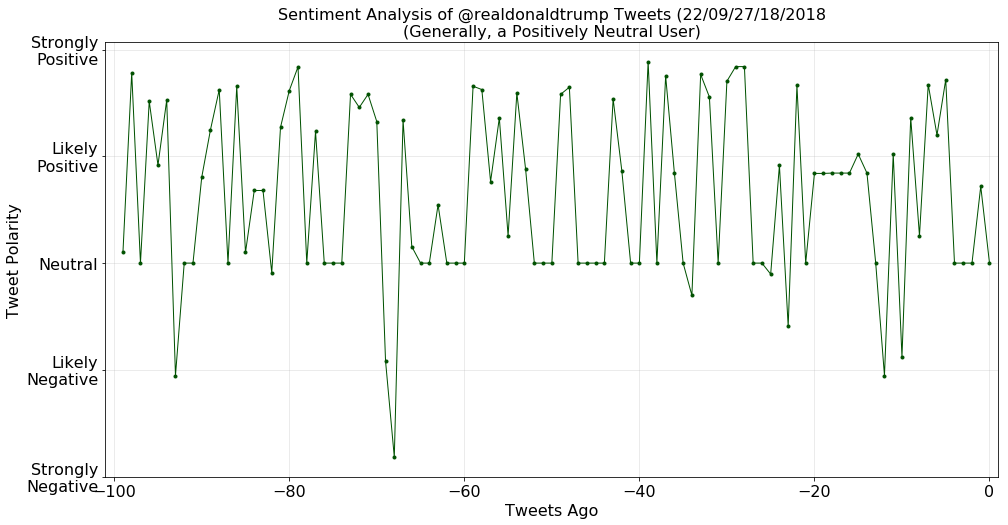

In [101]:
plot_analysis(data, 'realdonaldtrump')